In [14]:
import os
from Significance_func import *
import numpy as np
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import load
import pickle
import imageio

import sys
sys.path.append('../utils/')
from DD_data_extractor_git import Data_extractor_v4, output_vars_v4, flatten_2D_list

In [15]:
path = "/data/hnl/prompt_tau/anatuple/nanoV10/TEST10/"
features = deepcopy(output_vars_v4)
features.extend(['signal_label', 'channel', 'event_type', 'mass_hyp'])
channels = ['tee', 'tem', 'tmm', 'tte', 'ttm']
relative_path = "/anatuple/"

# Preprocessing #
1. **Defining paths and features:** The script first defines the directory path to the data, lists the features of interest in the data, and specifies the channels to be analyzed. 

2. **Preparing the data structure:** It then initializes a dictionary where the keys are the features and the values are empty lists. This dictionary, `data`, will be populated with values as the script runs.

3. **Loading and processing the data:** The script loads a pickled DataFrame `test` that contains the extracted data. It then removes the feature 'signal_label' from the list of DataFrame columns `flat_feat`.

4. **Function - `process_dataframe`:** The function `process_dataframe` is called with the DataFrame and the modified list of features as arguments. This function processes the DataFrame and organizes it in a specific way (look at the function's docstring for more info). The output, `channels_data`, is a nested dictionary where the first key level is the channels ('tee', 'tem', etc.) and the second key level is the event type ('signal', 'background'). The values in this dictionary are DataFrames containing the data for the respective channel and event type.

5. **Function - `process_channels`:** Finally, the function `process_channels` is called with the list of channels, the list of features, the data directory path, the relative path, and the initialized dictionary `data` as arguments. This function further processes the data according to the channels specified. The output, `All_channel_dict`, is a nested dictionary similar to `channels_data`, but includes additional processing and organization based on the channels.

The final output of the script is the `All_channel_dict` dictionary, which contains the processed and organized data ready for further analysis.


In [16]:
#If you want to use all data use All_data=True but if you just want 
#to use the data from the test set use All_data=False
All_data=False

In [17]:
values = []
flat_features = flatten_2D_list(features)
for i in range(len(flat_features)):
    values.append([])
data = dict(zip(flat_features, values))

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
output_dir = os.path.join(parent_dir,"saved_files", "extracted_data")
testdir = os.path.join(output_dir, "TEST10_test_aug3")


if not os.path.exists(testdir):
    All_data=True
    print("No extracted test data found, extracting all data from scratch")

if All_data:
    All_channel_dict=process_channels(channels, flat_features, path, relative_path, data)


else:

    test = pd.read_pickle(output_dir + '/TEST10_test_aug3')
    # print(test.columns)
    flat_feat=test.columns.to_list()
    # print(type(flat_feat))
    flat_feat.remove('signal_label')

    # Call the function
    channels_data = process_dataframe(test, flat_feat)

    print(channels_data['tee']['background'].keys())

    All_channel_dict =channels_data



dict_keys(['event', 'genWeight', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'mass_12', 'mass_13', 'mass_23', 'mass_123', 'Mt_tot', 'HNL_CM_angle_with_MET_1', 'HNL_CM_an

# Histogram Making # 
This script primarily uses a DNN model to generate scores that will be used to create histograms. The key functions and steps involved are:

1. **Loading the DNN model:** The script first loads a previously trained DNN model from a saved path. The model is a simple DNN with one input layer, one output layer, and ReLU and Sigmoid activation functions. The model was trained on a subset of the features and saved along with the scaler used for preprocessing the data.

2. **Defining the model inputs:** The features to be fed into the DNN are selected and added to `simpleselection` list along with 'weightNorm' and 'signal_label'.

3. **Calling the `get_dnn_score_dict_torch_simple` function:** This function applies the DNN model to the processed data (`All_channel_dict`), generates scores, and returns a nested dictionary similar to `All_channel_dict` but with an additional key 'scores' that contains the DNN scores for each channel and event type.

The output of this script is the `simple_dnndict` dictionary, which make a copy of the original dictionary and appends the DNN scores for each channel and event type, and can be used for further analysis and visualization, such as generating histograms.



In [12]:
from DNN_models import DNN_simple

cdpath4="/home/ddemler/dmitri_stuff/"
save_path = os.path.join(cdpath4, 'saved_models/', 'simple_dnn')
save_name = '/simple1_nelsonnorm3_depth2_5epochs'

with open(save_path + '/scaler1.pkl', 'rb') as f:
    scaler = pickle.load(f)

model_selection = ['Mt_tot', 'mass_hyp', 'HNL_CM_mass_1', 'HNL_CM_mass_2', 'mt_1MET']

simpleselection = model_selection.copy()
simpleselection.append('weightNorm')
simpleselection.append('signal_label')


model_class = DNN_simple(model_selection)
model_class.load_state_dict(load(save_path + save_name + '.pt'))


simple_dnndict = get_dnn_score_dict_torch_simple(All_channel_dict, save_name,model_class, save_path, simpleselection, 800, scaler=scaler)
# _=binmaker_rightleft(simple_dnndict['ttm'], 'scores', 700, X=0.2, plot=True, Channelname='ttm')
# _=binmaker_rightleft(All_channel_dict['ttm'], 'Mt_tot', 700, X=0.2, plot=True, Channelname='ttm')
# _=binmaker(All_channel_dict['ttm'], 20, 'Mt_tot', 700, X=0.2, plot=True)


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

# Plotting Significance and comparing plots #
This script primarily focuses on visualizing the performance of a model that was obtained through a Neural Architecture Search (NAS) run on all input features. The key functions and steps involved are:

1. **Loading the model information:** The script first loads a pickled DataFrame, `model_info_list`, that contains information about the model. This information was saved during a NAS process where the model was trained on all input features.

2. **Calling the `plot_average_significance_withpd` function:** This function is used to visualize the average significance of the model's predictions. It takes as input the preprocessed data (`All_channel_dict`), a list of keys (['Mt_tot', 'scores']), the model information list (`model_info_list`), a list of binning functions (['binmaker_rightleft']), a cut-off value 'X', and other optional parameters. The function generates a plot that averages the significance over all channels and event types, and optionally prints the Area Under the Curve (AUC) for each channel.

The output of this script is a plot of the average significance of the model's predictions, which gives an indication of the model's performance and the degree to which it can differentiate between signal and background events in the data.



Mass_hyps: 1000.0, xvariable: Mt_tot, binmaker: binmaker_rightleft, model: /DNN_saved1: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]
Mass_hyps: 1000.0, xvariable: scores, binmaker: binmaker_rightleft, model: /DNN_saved1: 100%|██████████| 16/16 [01:20<00:00,  5.03s/it]
Mass_hyps: 1000.0, xvariable: scores, binmaker: binmaker_rightleft, model: /DNN_saved2: 100%|██████████| 16/16 [01:20<00:00,  5.04s/it]
Mass_hyps: 1000.0, xvariable: scores, binmaker: binmaker_rightleft, model: /DNN_saved3: 100%|██████████| 16/16 [01:20<00:00,  5.02s/it]
Mass_hyps: 1000.0, xvariable: scores, binmaker: binmaker_rightleft, model: /DNN_saved4: 100%|██████████| 16/16 [01:22<00:00,  5.14s/it]
Mass_hyps: 1000.0, xvariable: scores, binmaker: binmaker_rightleft, model: /DNN_saved5: 100%|██████████| 16/16 [01:21<00:00,  5.07s/it]
Mass_hyps: 1000.0, xvariable: scores, binmaker: binmaker_rightleft, model: /DNN_saved6: 100%|██████████| 16/16 [01:22<00:00,  5.14s/it]
Mass_hyps: 1000.0, xvariable: scores, binmaker: 

Ordered list of models by AUC:
Model: /DNN_saved1, AUC: 582265.8636615808
Model: /DNN_saved4, AUC: 564853.5345819303
Model: /DNN_saved8, AUC: 561468.7013208353
Model: /DNN_saved3, AUC: 535235.6520649452
Model: /DNN_saved11, AUC: 534378.7215773676
Model: /DNN_saved2, AUC: 529722.7029573163
Model: /DNN_saved9, AUC: 524903.9380168633
Model: /DNN_saved10, AUC: 519890.6586464644
Model: /DNN_saved6, AUC: 519139.41653385607
Model: /DNN_saved5, AUC: 501209.0304134232
Model: /DNN_saved12, AUC: 494878.68277428683
Model: /DNN_saved7, AUC: 490283.77992653905


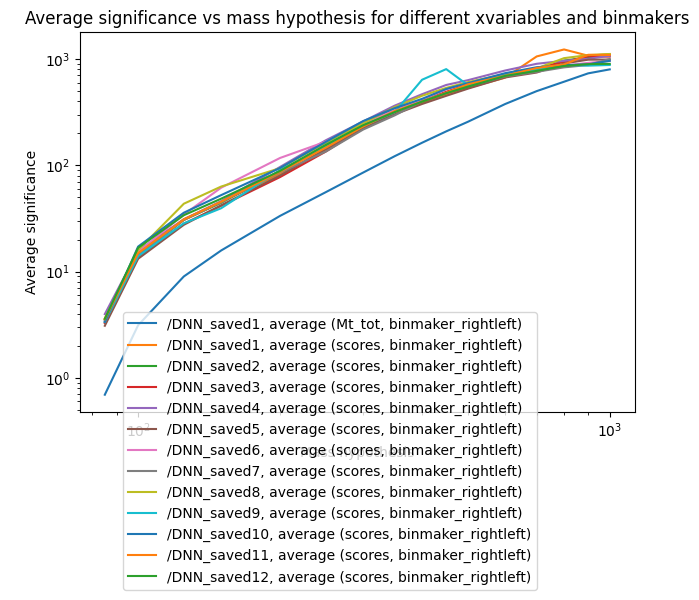

In [ ]:
cdpath="/home/ddemler/dmitri_stuff/"

save_path = os.path.join(cdpath, 'saved_models/', 'simple_dnn', 'NAS3')
model_info_list=pd.read_pickle(save_path + '/model_info_list3.pkl')
# print(model_info_list.head())

save_path = os.path.join(cdpath, 'saved_models/', 'simple_dnn', 'NAS3')
model_info_list=pd.read_pickle(save_path + '/model_info_list3.pkl')
# print(model_info_list.head())
plot_average_significance_withpd(All_channel_dict, ['Mt_tot', 'scores'], model_info_list, ['binmaker_rightleft'], X=0.15, hide_errorbars=True, print_AUC=True)